# IMPORTS

## Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Data

In [2]:
from novelty_detection.data import load_data
data = load_data("banknote_authentication.txt", header_names=['x1', 'x2', 'x3', 'x4', 'y'])
print(data.shape)
data.head()

(1372, 5)


,x1,x2,x3,x4,y
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# PREPROCESSING

In [3]:
X=data[['x1', 'x2', 'x3', 'x4']].to_numpy()
y=data[['y']].to_numpy()

## Split

In [4]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (1097, 4)
y train shape:  (1097, 1)
x test shape:  (275, 4)
x test shape:  (275, 1)


## Scale

In [5]:
from novelty_detection.preprocessing import minmax_scaler
train_x_norm = minmax_scaler(train_x)
test_x_norm = minmax_scaler(test_x)
X_norm = minmax_scaler(X)

# TRAINING

In [6]:
from novelty_detection.som import SOM

model=SOM(som_grid_size=(10,10),
          max_distance=4,
          learning_rate_0=0.5,
          max_iter=10000,
          random_state=40,
          methods={'init_som': 'uniform',
                    'bmu_distance': 'cityblock',
                    'compute_neighborhood': 'ceil',
                    'update_sigma_and_learning_rate': 'linear'})

model=model.fit(train_x_norm)

## SOM data visualization with PCA

Convert som data (3d array) to data i a dataset structure (every row is a cell from the som matrix)

In [7]:
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

In [8]:
# 2D vizualization
pca = PCA(n_components = 2)
X2D = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca = PCA(n_components = 3)
X3D = pca.fit_transform(som_dataset)

# Amount of explained variance kept 3D
exp_variance_3d = pca.explained_variance_ratio_
print(f"3D: Total = {np.sum(exp_variance_3d)} and per components = {exp_variance_3d}")

2D: Total = 0.9026751788465466 and per components = [0.58933637 0.31333881]
3D: Total = 0.9735138584783236 and per components = [0.58933637 0.31333881 0.07083868]


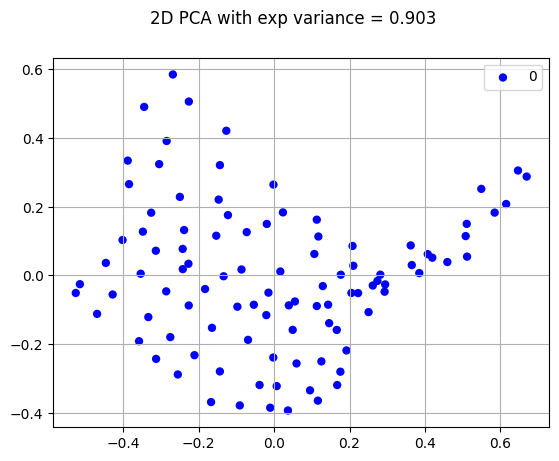

In [9]:
y_flat = y.ravel()

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(X2D[:,0], X2D[:,1], color="blue", label="0", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle(f"2D PCA with exp variance = {round(np.sum(exp_variance_2d), 3)}")

plt.show()

## Continuosly update SOM

In [10]:
trained_som = som
# sigma and lr values from the last iteration of the training process
trained_lr = model.learning_rate_final 
trained_sigma = model.sigma_final
new_measure = test_x_norm[0]
new_iter=model.max_iter+1
new_som = model.update_som(new_measure, trained_som, trained_lr, trained_sigma)
new_lr, new_sigma = model.update_sigma_and_learning_rate(new_iter, model.methods['update_sigma_and_learning_rate'])

# NOVELTY DETECTION

## KNN novelty detector

In [11]:
from novelty_detection.som_novelty_detectors import KNN

model=KNN(som,
          min_number_per_bmu=1,
          number_of_neighbors=3)

metric=model.evaluate(test_x_norm)

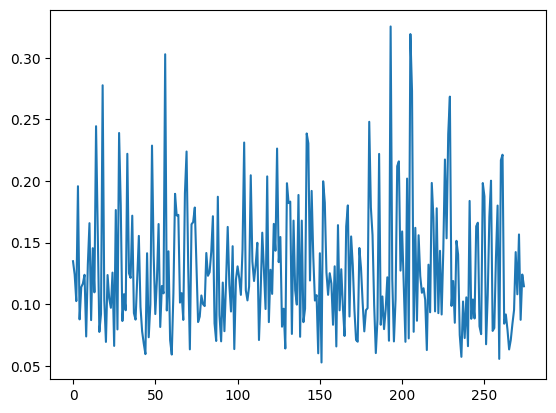

In [12]:
plt.plot(np.arange(test_x_norm.shape[0]), metric)

## Quantization error novelty detector

In [30]:
from novelty_detection.som_novelty_detectors import Quantization_Error

model=Quantization_Error(som)
metric=model.evaluate(train_x_norm, test_x_norm)

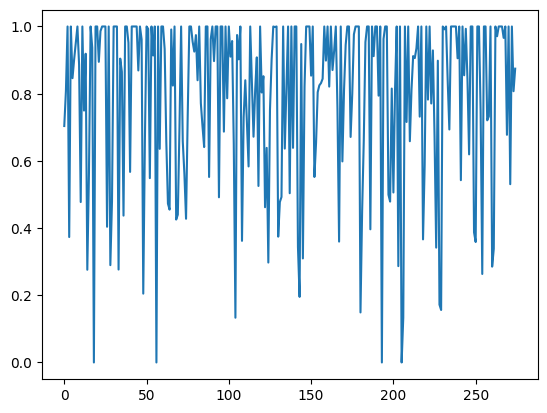

In [31]:
plt.plot(np.arange(test_x_norm.shape[0]), metric)

In [24]:
l_dmin = model.find_dmin(train_x_norm, som)
dmax_training = np.max(l_dmin) - np.min(l_dmin)
Eq_training = np.sum(l_dmin) / train_x_norm.shape[0]
Eq = model.find_dmin(test_x_norm, som)
Eq = np.array(Eq)
Nd = np.zeros((test_x_norm.shape[0],))
Nd[Eq<=Eq_training] = 1
condition = (Eq > Eq_training) & (Eq < dmax_training)
Nd[condition] = 1 - (Eq[condition] - Eq_training) / (dmax_training - Eq_training)
Nd[Eq>dmax_training] = 0

In [26]:
dmax_training

0.23495220787095172

In [29]:
np.array(l_dmin).max()

0.24296018867225888